In [21]:
import numpy as np
from scipy.stats import pearsonr

import NPI

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# --- baseline run config (no noise notebook) ---
SEED = 42

import random, numpy as np
try:
    import torch
except ImportError:
    torch = None

random.seed(SEED)
np.random.seed(SEED)
if torch:
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [23]:
def flat_without_diagonal(matrix):

    "Flatten the matrix without including the diagonal"
    
    n = matrix.shape[0]
    flattened = []
    for i in range(n):
        for j in list(range(i)) + list(range(i + 1, n)):
            flattened.append(matrix[i][j])
    
    return np.array(flattened)

### **NPI usage demo**

In [24]:
batch_size              = 50
train_set_proportion    = 0.8
ROI_num                 = 20
using_steps             = 3

In [25]:
signals = np.loadtxt('./RNN_simulation_data/sim_data/dynamics_020nodes_8000steps_00seed.txt')
SC      = np.loadtxt('./RNN_simulation_data/sim_data/SC_020nodes_8000steps_00seed.txt')
real_EC = np.loadtxt('./RNN_simulation_data/sim_data/real_EC_020nodes_8000steps_00seed.txt')

##### train NN

Several ANNs (MLP, CNN, RNN, VAR) are provided in the NPI framework, which can be used as a surrogate brain.

In [26]:
inputs, targets = NPI.multi2one(signals, steps = using_steps)

ANN = NPI.ANN_MLP(input_dim = using_steps * ROI_num, hidden_dim = 2 * ROI_num, latent_dim = int(0.8 * ROI_num), output_dim = ROI_num)
# ANN = NPI.ANN_CNN(in_channels = ROI_num, hidden_channels = 3 * ROI_num, out_channels = ROI_num, data_length = using_steps)
# ANN = NPI.ANN_RNN(input_dim = ROI_num, hidden_dim = int(2.5 * ROI_num), latent_dim = int(2.5 * ROI_num), output_dim = ROI_num, data_length = using_steps)
# ANN = NPI.ANN_VAR(input_dim = using_steps * ROI_num, output_dim = ROI_num)

ANN, training_loss, testing_loss = NPI.train_NN(ANN, inputs, targets, batch_size, train_set_proportion, num_epochs = 80, lr = 2e-4, l2 = 5e-5)

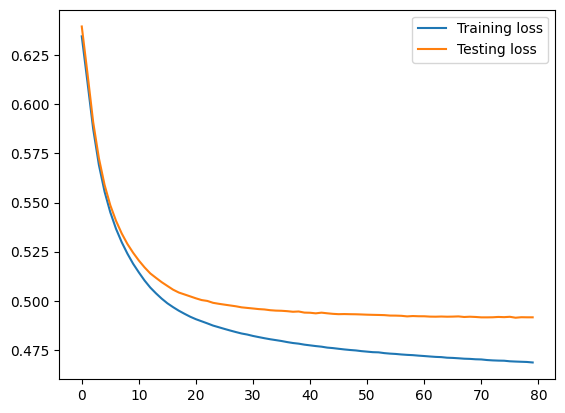

In [27]:
plt.plot(training_loss, label = 'Training loss')
plt.plot(testing_loss, label = 'Testing loss')
plt.legend(loc = 'upper right')
plt.show()

##### calculate empirical FC & model FC

In [28]:
empirical_FC = NPI.corrcoef(signals)
model_FC = NPI.model_FC(ANN, node_num = ROI_num, steps = using_steps)

##### calculate NPI Inferred EC

In [29]:
NPI_EC = NPI.model_EC(ANN, inputs, targets, pert_strength = 1.0)
np.fill_diagonal(NPI_EC, 0)

##### calculate model Jacobian

In [30]:
NPI_Jacobian = NPI.model_Jacobian(ANN, inputs, steps = using_steps)
np.fill_diagonal(NPI_Jacobian, 0)

##### empirical FC - model FC comparison

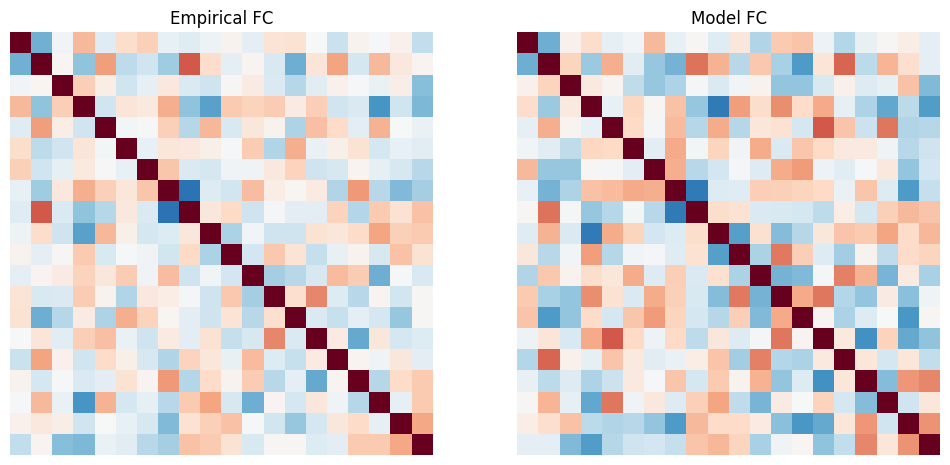

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(empirical_FC, ax = ax1, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(model_FC, ax = ax2, vmin = -1.0, vmax = 1.0, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Empirical FC'); ax2.set_title('Model FC')
plt.show()

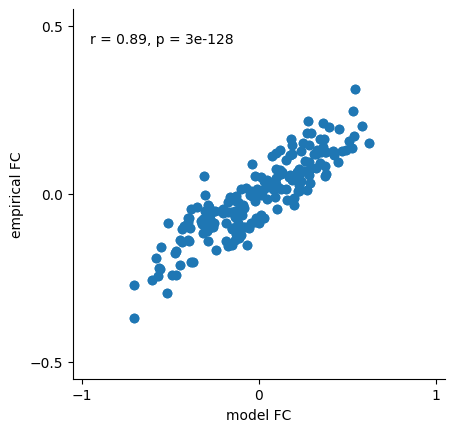

In [32]:
r_value, p_value = pearsonr(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.xlim(-1.05, 1.05); plt.xticks([-1.0, 0.0, 1.0]); plt.xlabel('model FC')
plt.ylim(-0.55, 0.55); plt.yticks([-0.5, 0.0, 0.5]); plt.ylabel('empirical FC')
plt.text(-0.95, 0.45, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### real EC - NPI EC comparison

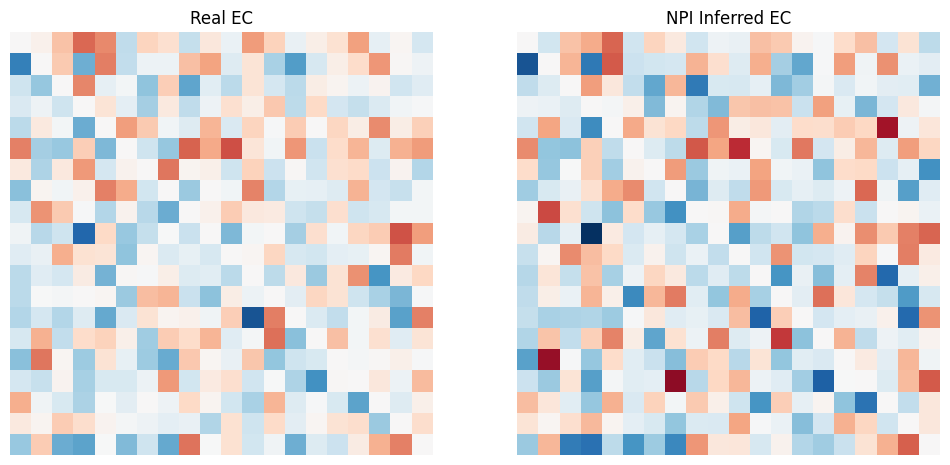

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(real_EC, ax = ax1, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(NPI_EC, ax = ax2, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Real EC'); ax2.set_title('NPI Inferred EC')
plt.show()

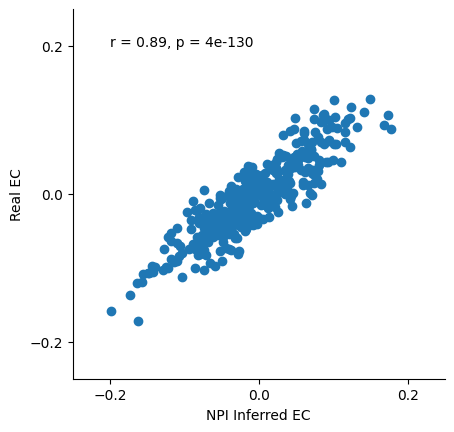

In [34]:
r_value, p_value = pearsonr(flat_without_diagonal(NPI_EC), flat_without_diagonal(real_EC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(NPI_EC), flat_without_diagonal(real_EC))

plt.xlim(-0.25, 0.25); plt.xticks([-0.2, 0.0, 0.2]); plt.xlabel('NPI Inferred EC')
plt.ylim(-0.25, 0.25); plt.yticks([-0.2, 0.0, 0.2]); plt.ylabel('Real EC')
plt.text(-0.2, 0.2, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### real EC - model Jacobian comparison

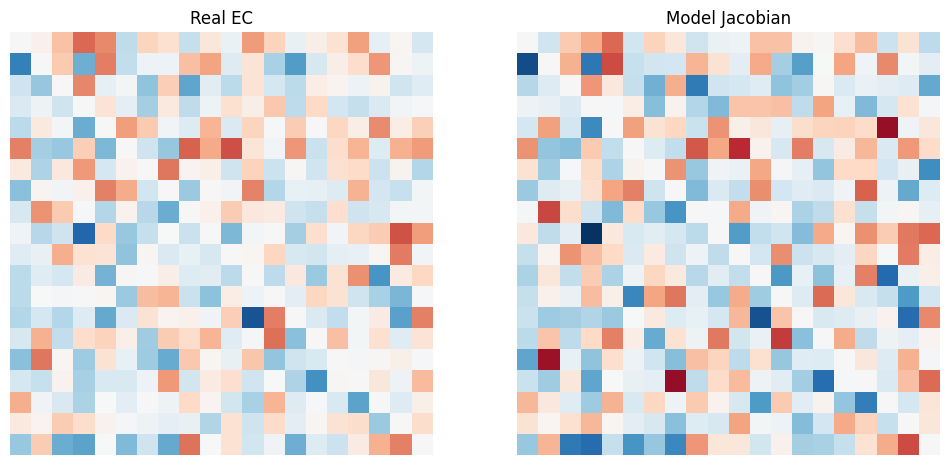

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(real_EC, ax = ax1, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(NPI_Jacobian, ax = ax2, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Real EC'); ax2.set_title('Model Jacobian')
plt.show()

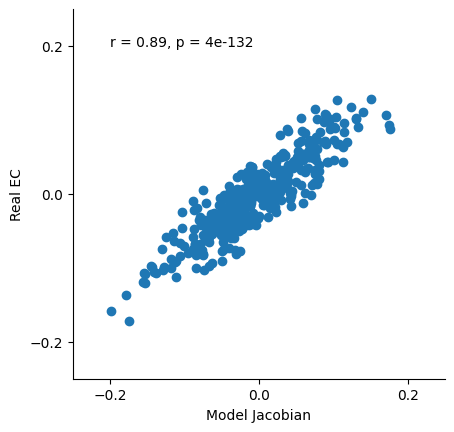

In [36]:
r_value, p_value = pearsonr(flat_without_diagonal(NPI_Jacobian), flat_without_diagonal(real_EC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(NPI_Jacobian), flat_without_diagonal(real_EC))

plt.xlim(-0.25, 0.25); plt.xticks([-0.2, 0.0, 0.2]); plt.xlabel('Model Jacobian')
plt.ylim(-0.25, 0.25); plt.yticks([-0.2, 0.0, 0.2]); plt.ylabel('Real EC')
plt.text(-0.2, 0.2, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### SC - NPI EC comparison

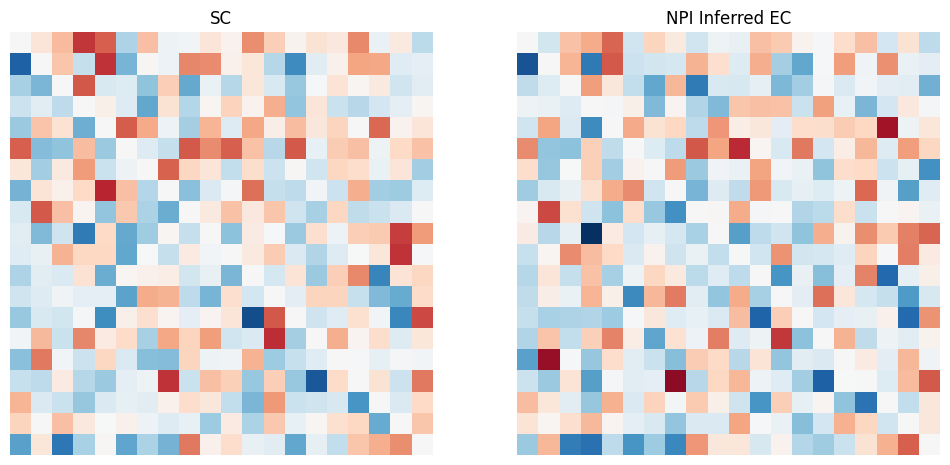

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(SC, ax = ax1, vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(NPI_EC, ax = ax2, vmin = -0.2, vmax = 0.2, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('SC'); ax2.set_title('NPI Inferred EC')
plt.show()

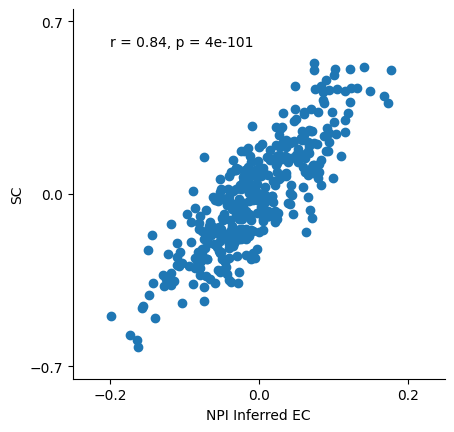

In [38]:
r_value, p_value = pearsonr(flat_without_diagonal(NPI_EC), flat_without_diagonal(SC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(NPI_EC), flat_without_diagonal(SC))

plt.xlim(-0.25, 0.25); plt.xticks([-0.2, 0.0, 0.2]); plt.xlabel('NPI Inferred EC')
plt.ylim(-0.75, 0.75); plt.yticks([-0.7, 0.0, 0.7]); plt.ylabel('SC')
plt.text(-0.2, 0.6, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### Group-level analysis

In [39]:
NPIFC_empiricalFC_corr = []
NPIEC_realEC_corr = []
NPIEC_SC_corr = []

for i in range(50):

    signals = np.loadtxt('./RNN_simulation_data/sim_data/dynamics_020nodes_8000steps_{:02d}seed.txt'.format(i))
    SC      = np.loadtxt('./RNN_simulation_data/sim_data/SC_020nodes_8000steps_{:02d}seed.txt'.format(i))
    real_EC = np.loadtxt('./RNN_simulation_data/sim_data/real_EC_020nodes_8000steps_{:02d}seed.txt'.format(i))

    inputs, targets = NPI.multi2one(signals, steps = 3)
    ANN = NPI.ANN_MLP(input_dim = using_steps * ROI_num, hidden_dim = 2 * ROI_num, latent_dim = int(0.8 * ROI_num), output_dim = ROI_num)
    ANN, training_loss, testing_loss = NPI.train_NN(ANN, inputs, targets, num_epochs = 80, lr = 2e-4, l2 = 5e-5)

    empirical_FC = NPI.corrcoef(signals)
    model_FC = NPI.model_FC(ANN, node_num = ROI_num, steps = 3)
    NPIFC_empiricalFC_corr.append(pearsonr(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))[0])

    NPI_EC = NPI.model_EC(ANN, inputs, targets, pert_strength = 1.0)
    np.fill_diagonal(NPI_EC, 0)
    NPIEC_realEC_corr.append(pearsonr(flat_without_diagonal(NPI_EC), flat_without_diagonal(real_EC))[0])
    NPIEC_SC_corr.append(pearsonr(flat_without_diagonal(NPI_EC), flat_without_diagonal(SC))[0])

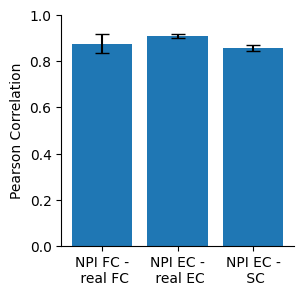

In [40]:
categories = ['NPI FC -\n real FC', 'NPI EC -\n real EC', 'NPI EC -\n SC']
values = [np.mean(NPIFC_empiricalFC_corr), np.mean(NPIEC_realEC_corr), np.mean(NPIEC_SC_corr)]
stds = [np.std(NPIFC_empiricalFC_corr), np.std(NPIEC_realEC_corr), np.std(NPIEC_SC_corr)]

plt.figure(figsize = (3, 3))
plt.bar(categories, values, yerr = stds, capsize = 5)
plt.ylabel('Pearson Correlation')
plt.ylim(0, 1)

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

In [42]:
import os, numpy as np, pandas as pd

def pick(*names):
    g = globals()
    for n in names:
        if n in g:
            return g[n]
    raise NameError(f"Could not find any of: {names}")

def upper_tri(m):
    m = np.asarray(m)
    i = np.triu_indices_from(m, k=1)
    return m[i]

def fc_corr_from_any(emp_fc, mdl_fc):
    a = upper_tri(emp_fc)
    b = upper_tri(mdl_fc)
    return float(np.corrcoef(a, b)[0, 1])

# Try common names used in FC comparison cells
emp_fc = pick("empirical_FC", "empirical_fc", "FC_empirical", "FC_emp")
mdl_fc = pick("model_FC", "model_fc", "FC_model", "fc_model")

fc_corr = fc_corr_from_any(emp_fc, mdl_fc)

row = {
    "demo": "RNN",          # change to "WBM" if you're in that notebook
    "snr": "baseline",
    "mode": "none",
    "seed": SEED,
    "metric": "fc_corr",
    "value": fc_corr,
}
csv_path = "results_snr_sweep.csv"
pd.DataFrame([row]).to_csv(csv_path, mode="a", header=not os.path.exists(csv_path), index=False)
print("Appended to", csv_path, row)


Appended to results_snr_sweep.csv {'demo': 'RNN', 'snr': 'baseline', 'mode': 'none', 'seed': 42, 'metric': 'fc_corr', 'value': 0.9100382860076035}
